In [55]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
from typing import List, Tuple
import warnings
from common_util import LogLinearArrhenius,LogLinearArrheniusModelFunc, setup_axis_default,hdi
import pickle
from scipy.optimize import bisect
from scipy.interpolate import interp1d  
from scipy.signal import savgol_filter

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

SECONDS_TO_HOURS = 3600.0
HOURS_TO_YEAR = 24.0*365.0
SECONDS_TO_YEAR = SECONDS_TO_HOURS*HOURS_TO_YEAR

def get_arrhenius_process_params(ap: LogLinearArrhenius) -> np.ndarray:
    return ap.params[0],ap.params[1]

def get_model_ap_params(model: LogLinearArrheniusModelFunc) -> np.ndarray:
    return (*get_arrhenius_process_params(model.ap1),*get_arrhenius_process_params(model.ap2))

def get_model_params(model: LogLinearArrheniusModelFunc) -> np.ndarray:
    return *get_model_ap_params(model),model.n

class InvertedJMAK:

    def __init__(self,jmak_model: LogLinearArrheniusModelFunc | np.ndarray):
        if isinstance(jmak_model,np.ndarray):
            self.ap1 = LogLinearArrhenius(jmak_model[0:2])
            self.ap2 = LogLinearArrhenius(jmak_model[2:4])
            self.n = jmak_model[4]
            self.jmak_model = None
        
        else:
            self.jmak_model = jmak_model
            self.ap1 = jmak_model.ap1
            self.ap2 = jmak_model.ap2
            self.n = jmak_model.n
    
    def get_time(self, X: np.ndarray,T: np.ndarray) -> np.ndarray:

        tinc = self.ap2(T)
        b = self.ap1(T)
        return 1.0/b*np.log(1./(1. - X))**(1/self.n) + tinc   

    def get_temperature(self, X: np.ndarray,
                              t: np.ndarray,
                              T_bounds: Tuple = (873.15,2273.15)) -> np.ndarray:
        
        def _search_function(T: float) -> float:
            return self.get_time(X,np.array([T])) - t

        return bisect(_search_function,*T_bounds)

def get_time_from_jmak_samples(X: np.ndarray,
                                T: np.ndarray,
                                a1: np.ndarray,
                                a2: np.ndarray,
                                B1: np.ndarray,
                                B2: np.ndarray,
                                n: np.ndarray) -> np.ndarray:
    
    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    return 1.0/b*np.log(1./(1. - X))**(1/n) + t_inc  

def jmak_prediction_from_samples(t: np.ndarray,
                                 T: np.ndarray,
                                 a1: np.ndarray,
                                 a2: np.ndarray,
                                 B1: np.ndarray,
                                 B2: np.ndarray,
                                 n: np.ndarray) -> np.ndarray:
        
    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    t_eff = t - t_inc
    t_eff[t_eff < 0.] = 0.0   

    return 1. - np.exp(-(b**n*t_eff**n))

file_to_label  = {'rf_data/alfonso_data/highly_rolled.csv': 'Lopez et al. (2015) - HR',
                'rf_data/alfonso_data/moderate_roll.csv': 'Lopez et al. (2015) - MR',
                'rf_data/richou_data/batch_a_data.csv': 'Richou et al. (2020) - Batch A',
                'rf_data/richou_data/batch_b_data.csv': 'Richou et al. (2020) - Batch B'}

933.9
862.9
(10000, 1000)
(1000, 2)
1104.5
1037.1
(10000, 1000)
(1000, 2)


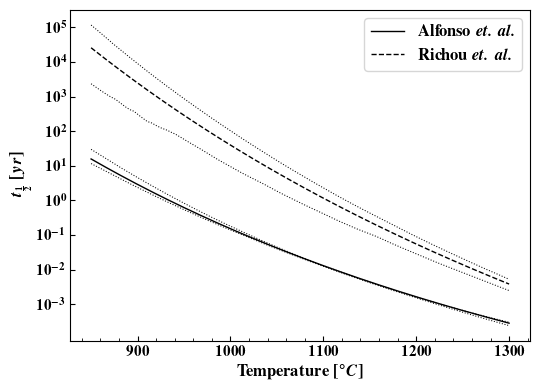

In [40]:

styles = ['-','--']
labels = [r'\textbf{Alfonso \textit{et. al.}}',r'\textbf{Richou \textit{et. al.}}']

fig,ax = plt.subplots(figsize = (5.5,4))
setup_axis_default(ax)
ax.set_xlabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)
ax.set_ylabel(r'\textbf{$t_{\frac{1}{2}}$ [$yr$]}',fontsize = 12)

files = ['rf_data/alfonso_data/highly_rolled.csv','rf_data/richou_data/batch_a_data.csv']
model_name = 'JMAK_{}'
T = np.linspace(850,1300,1000) + 273.15
for style,label,file in zip(styles,labels,files):
    
    with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','rb') as f:
        posterior_samples = pickle.load(f)
    
    map_params =  pd.read_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv',index_col = 0)

    
    ijmak_model = InvertedJMAK(map_params.loc[['a1','B1','a2','B2','n'],'ml'].to_numpy())
    
    for time in [1,10]:
        temp = ijmak_model.get_temperature(0.5,time*SECONDS_TO_YEAR)
        print(round(temp - 273.15,1))

    t = ijmak_model.get_time(0.5,T)

    ax.plot(T-273.15,t/SECONDS_TO_YEAR,color = 'k',lw = 1.0,ls = style,label = label)

    
    samples_time = get_time_from_jmak_samples(0.5,T[np.newaxis,:],
                                              posterior_samples['a1'][:,np.newaxis],
                                              posterior_samples['a2'][:,np.newaxis],
                                              posterior_samples['B1'][:,np.newaxis],
                                              posterior_samples['B2'][:,np.newaxis],
                                              posterior_samples['n'][:,np.newaxis])
    
    print(samples_time.shape)
    out = hdi(samples_time.T,0.95)
    print(out.shape)
    for i in range(2):
        filtered = savgol_filter(out[:,i],100,3)
        ax.plot(T-273.15,filtered/SECONDS_TO_YEAR,lw = 0.75,ls = ':',color = 'k')
    

ax.set_yscale('log')
ax.legend(fontsize = 12)

fig.tight_layout()
labels = np.logspace(-3,5,9)
ax.set_yticks(labels)
fig.savefig('.temp_images/half_time_vs_temp.svg')



### Comparison with Nogami Data

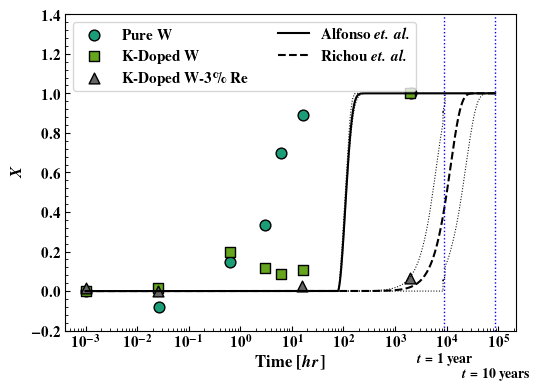

In [64]:
pure_w_df = pd.read_csv('rf_data/tschudia_data/tschudia_data_T_1100CPure W Data.csv',index_col = None)
k_doped_w_df = pd.read_csv('rf_data/tschudia_data/tschudia_data_T_1100CK-doped W Data.csv',index_col = None)
for df in [pure_w_df,k_doped_w_df]:
    df['X']  = 1 + (df['hardness'].min()  - df['hardness'])/(df['hardness'].iloc[0] - df['hardness'].min())

k_doped_re3_w_df = pd.read_csv('rf_data/tschudia_data/tschudia_data_T_1100CK-doped W-3Re Data.csv',index_col = None)
k_doped_re3_w_df['X'] = 1 - (k_doped_re3_w_df['hardness'] - 0.208*k_doped_re3_w_df['hardness'].max())/(k_doped_re3_w_df['hardness'].max() - k_doped_re3_w_df['hardness'].max()*0.208)
fig,ax = plt.subplots(figsize = (5.5,4))

setup_axis_default(ax)
ax.set_xlabel(r'\textbf{Time [$hr$]}',fontsize = 12)
ax.set_ylabel(r'$X$',fontsize = 12)

symbols = ['o','s','^']
colors = plt.get_cmap('Dark2')(np.linspace(0.1,0.9,len(symbols)))
labels = [r'Pure W',r'K-Doped W',r'K-Doped W-3\% Re'] 

min_t = float('inf')
max_t = -float('inf')
for df,color,symbol,label in zip([pure_w_df,k_doped_w_df,k_doped_re3_w_df],colors,symbols,labels):
    ax.scatter(df['time [hr]'],df['X'],facecolor = color,edgecolor = 'k',s = 60,
               marker = symbol,label = r'\textbf{' + label + r'}')
    min_t = min(min_t,df['time [hr]'].min())
    max_t = max(max_t,df['time [hr]'].max())


files = ['rf_data/alfonso_data/highly_rolled.csv','rf_data/richou_data/batch_a_data.csv']
model_name = 'JMAK_{}'

styles = ['-','--']
labels = [r'\textbf{Alfonso \textit{et. al.}}',r'\textbf{Richou \textit{et. al.}}']


time = np.linspace(min_t,HOURS_TO_YEAR*10,int(1e5))*SECONDS_TO_HOURS
temperature = np.ones_like(time)*1100.0 + 273.15

for file,style,label in zip(files,styles,labels):
    
    with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','rb') as f:
        posterior_samples = pickle.load(f)
    
    
    X_samples = jmak_prediction_from_samples(time[np.newaxis,:],
                                             temperature[np.newaxis,:],
                                             posterior_samples['a1'][:,np.newaxis],
                                              posterior_samples['a2'][:,np.newaxis],
                                              posterior_samples['B1'][:,np.newaxis],
                                              posterior_samples['B2'][:,np.newaxis],
                                              posterior_samples['n'][:,np.newaxis])
    
    intervals_X = hdi(X_samples.T,0.95)
    for i in range(2):
        #filtered = savgol_filter(intervals_X[:,i],100,3)
        ax.plot(time/SECONDS_TO_HOURS,intervals_X[:,i],color = 'k',lw = 0.75,ls = ':')
    
    
    map_est = pd.read_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv',index_col = 0)
    map_est= map_est.loc[['a1','a2','B1','B2','n'],'ml'].to_numpy()
    map_est= [np.array([[a]]) for a in map_est]    
    X_map= jmak_prediction_from_samples(time[np.newaxis,:],
                                             temperature[np.newaxis,:],
                                            *map_est)
    

    ax.plot(time/SECONDS_TO_HOURS,X_map.squeeze(),color = 'k',lw = 1.5,ls = style,label = label)

ax.axvline(HOURS_TO_YEAR*1,color = 'blue',lw = 1.0,ls = ':')
ax.axvline(HOURS_TO_YEAR*10,color = 'blue',lw = 1.0,ls = ':')

ax.text(HOURS_TO_YEAR*1, ax.get_ylim()[0] - 0.175, r'\textbf{$t$ = 1 year}', color='k', ha='center', va='top')
ax.text(HOURS_TO_YEAR*10, ax.get_ylim()[0] - 0.25, r'\textbf{$t$ = 10 years}', color='k', ha='center', va='top')


ax.set_xscale('log')
ax.set_ylim([-0.2,1.4])
ax.legend(fontsize = 11,ncols = 2,loc = 'upper left')
fig.tight_layout()
fig.savefig('.temp_images/nogami_rx_comp.svg')





### Example Transient Profile

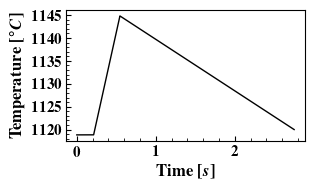

In [131]:
from scipy.optimize import curve_fit
class PiecewiseLinearTemperatureProfile:

    def __init__(self,t: np.ndarray,T: np.ndarray):
        self.t = t
        self.T = T

    def find_break_points(self) -> List[int]:
        break_points = []
        self.bp_index = []
        for i in range(self.t.shape[0]):
            if self.T[i] != self.T[0]:
                break_points.append(self.t[i])
                self.bp_index.append(i)
                break
        
        break_points.append(self.t[np.argmax(self.T)]) 
        self.bp_index.append(np.argmax(self.T))
        self.break_points = break_points
    
    def _piecewise_linear(self,t: np.ndarray,b2: float,b3: float):
        a1 =  self.T[0]
        a2 = a1 - b2*self.t[self.bp_index[0]]
        a3 = a2 + (b2 - b3)*self.t[self.bp_index[1]]
        return np.piecewise(t,[t <= self.break_points[0],
                             np.all(np.array([t > self.break_points[0],t <= self.break_points[1]]).T,axis = 1),
                             t > self.break_points[1]],
                             [lambda x: self.T[0],
                              lambda x: a2 + b2*x,
                              lambda x: a3 + b3*x])
    

    def fit(self):
        self.find_break_points()
        init_slope = (self.T.max() - self.T.min())/(self.t.max() - self.t.min())
        self.params = curve_fit(self._piecewise_linear,self.t,self.T,
                           p0 = [3*init_slope,-3*init_slope])[0]
        

    def __call__(self,t: np.ndarray) -> np.ndarray:
        return self._piecewise_linear(t,*self.params)

df = pd.read_csv('example_temperature_profile.csv')

fig,ax = plt.subplots(figsize = (3.25,2.0))
setup_axis_default(ax)
ax.set_xlabel(r'\textbf{Time [$s$]}',fontsize = 12)
ax.set_ylabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)

df.loc[df['t-pb-max'] < 1392,'t-pb-max'] = 1392

temp_model = PiecewiseLinearTemperatureProfile(df['flow-time'].to_numpy(),df['t-pb-max'].to_numpy())    
temp_model.fit()

time = np.linspace(0,2.75,int(1e4))
#ax.plot(df['flow-time'],df['t-pb-max'],color = 'k',lw = 1.0)
temp = temp_model(time)
ax.plot(time,temp - 273.15,color = 'k',lw = 1.0)
#ax.set_ylim([1380,1440])
ax.set_yticks(np.arange(1120,1150,5))
fig.tight_layout()

fig.savefig('.temp_images/piecewise_linear_temp_profile.svg')



In [141]:
import math
from typing import Callable
from scipy.integrate import quad

class RateFunc:

    def __init__(self,a: float,b: float, T: Callable):
        self.a = a
        self.b = b
        self.T = T
    
    def integrate_func(self,t: float):
        return math.exp(self.a + self.b/self.T(np.array([t])))
    
    def __call__(self,t: Tuple[float]) -> float:
        return quad(self.integrate_func,t[0],t[1])[0]   
        

file = 'rf_data/richou_data/batch_a_data.csv'
map_est = pd.read_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv',index_col = 0)
mean_t = temp_model(np.linspace(0,2.5,1000)).mean()
print(mean_t - 273.15)
rate_func_const = RateFunc(map_est.loc['a1','ml'],map_est.loc['B1','ml'],lambda x: mean_t)
rate_func_triangle = RateFunc(map_est.loc['a1','ml'],map_est.loc['B1','ml'],temp_model)

print(rate_func_triangle((0,2.5))/rate_func_const((0,2.5)))


1132.2595231122473
1.02635383734578


C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_18700\616652003.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.exp(self.a + self.b/self.T(np.array([t])))
